# Bayesian Networks
**COMP9418-20T3, W03 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista and Jeremy Gillen from a notebook developed by Daniel Mackinlay and Edwin V. Bonilla
- Last update 18th August 2021
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

In this week's tutorial, we will start exploring representation and inference with Bayesian networks.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using Google Colab or ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run this command:

```python
pip3 install pandas
```

To render a visualization of some graphical models, you also need to install [Graphviz](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed. If you do not have it and use the conda installation, then use the command ```conda install python-graphviz```. 

You will also need to download the preprocessed `icu_diag.csv` data set (see data file for this tutorial in WebCMS3) and put it in the same folder as this notebook.

Once we have done all that, we import some useful modules for later use.

In [1]:
# Necessary libraries
import numpy as np
import pandas as pd

# combinatorics
from itertools import product

Import classes from `DiscreteFactors.py` and `Graph.py` developed in previous tutorials. If you are using Colab, upload the files by clicking the "files"  button on the left side of the page, then the "upload files"  button. Then select the relevant python files.

In [2]:
from DiscreteFactors import Factor
from Graph import Graph


## `pandas`

We will be using an external library for the loading tabular data: `pandas.DataFrame` is somewhat similar to `R`. 
If you wish to know more about that, [check out the Pandas intro](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). We will mostly be ignoring this library, except to load data and display it in nice tables.



# The Data

## Loading the data

These data correspond to the problem in the theory part of the tutorial for this week, i.e. the Bayesian network for medical diagnosis in an intensive care unit (ICU). The data are in `csv` format.
We can load this in several ways in python, but the most convenient for this purpose 
is to load it as a `DataFrame` in `pandas`.

In [3]:
# Download data
!wget 'https://raw.githubusercontent.com/UNSW-COMP9418/Week03/main/icu_diag.csv'

data = pd.read_csv(open('icu_diag.csv'))

--2021-09-24 14:59:48--  https://raw.githubusercontent.com/UNSW-COMP9418/Week03/main/icu_diag.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18018 (18K) [text/plain]
Saving to: 'icu_diag.csv.1’

icu_diag.csv.1      100%[===================>]  17.60K  --.-KB/s    in 0.002s  

2021-09-24 14:59:49 (8.66 MB/s) - 'icu_diag.csv.1’ saved [18018/18018]



The loaded data frame is an attribute-value table. It contais 1000 rows (examples), each one correponding to a patient in the intensive care unit. Each row has nine colums (attributes). Each column correponds to one variable in the Bayesian network. The next figure illustrates the network.

![ICU Graph](img/ICU_graph.png "Graph exercise")

We can use the command ``data.head()`` to display the first $n$ rows (default = 5) of the data frame.

In [5]:
data.head()

,A,C,B,H,L,O,S,T,V
0,0,0,1,1,0,0,1,1,0
1,0,1,2,0,0,2,1,1,1
2,0,2,2,0,0,2,1,1,1
3,0,2,0,0,0,2,1,0,1
4,0,1,2,0,0,2,1,1,1


The values in the cariables are encoded as follows:

| Variable  |  Value  |  Coding |
| :-------: | :-----: | ------: |
| H, L, A   |  False  | 0       |
| H, L, A   |  True   | 1       |
| V, S, T   |  Low    | 0       |
| V, S, T   |  High   | 1       |
| C, O, B   |  Low    | 0       |
| C, O, B   |  Medium | 1       |
| C, O, B   |  High   | 2       |

For now, we will keep this encoding as provided in the data file. However, replacing the numerical codes by symbolic labels may improve the results readability. To keep this notebook short, we will leave this extension as an exercise.

# Representing a Bayesian Network

### Exercise

Let's first represent the graph using the Graph object discussed in the Week 1 tutorial. We created a stub for you.

In [3]:
graph = Graph({
    'L': ['S', 'V'],
    'H': ['S', 'V'],
    # TODO
})

Let's use GraphViz to display the graph representation, so we can assure we did not forget any edges

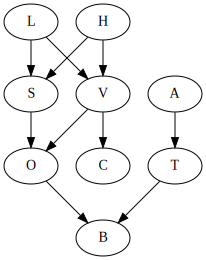

In [7]:
pos = {
    'L': '0,3!',
    'H': '1,3!',
    'S': '0,2!',
    'V': '1,2!',
    'A': '2,2!',
    'O': '0,1!',
    'C': '1,1!',
    'T': '2,1!',
    'B': '1,0!',
}
graph.show(positions=pos)

We will also need to declare a data structure with the possible outcomes for each variable.

In [13]:
# possible outcomes, by variable
outcomeSpace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)

Let's combine these two data structures to represent a Bayes net:

In [14]:
class BayesNet():
    def __init__(self, graph, outcomeSpace=None, factor_dict=None):
        self.graph = graph
        self.outcomeSpace = dict()
        self.factors = dict()
        if outcomeSpace is not None:
            self.outcomeSpace = outcomeSpace
        if factor_dict is not None:
            self.factors = factor_dict
        
model = BayesNet(graph, outcomeSpace)

Note that we have also introduced a variable called `factors`. The purpose of this variable is to hold all the factors associated with the connections in this Bayes Net. We could use a list here, or a set, but since each factor represents the relationship between a child node and its parents, it is convenient to label the factors with the name of the child node. E.g. `self.factors['B']` would contain the probability distribution $P(B|O,T)$.

# Estimating the probability tables from the data

We need to estimate a discrete distribution
for each (conditional) probability distribution.

Now we estimate parameters by constructing conditional distributions for each node in our graph.
We will take the proportions of empirical counts as estimates of the probabilities of the counted outcomes, i.e.
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x},\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N},
$$
and
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x}\mid\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N_\boldsymbol{y}},
$$

where $N_{\boldsymbol{x}, \boldsymbol{y}}$ is the number of observations of that outcome,
$$N_{\boldsymbol{x}, \boldsymbol{y}}:=\sum_i\boldsymbol{X_i}=\boldsymbol{x}\cap\boldsymbol{Y_i}=\boldsymbol{y},$$ and $N$ is the total number of observations.

Later, we will see this procedure of estimating parameters corresponds to the Maximum Likelihood Estimate (MLE).

Below is another helper function. This will calculate joint occurrence probability tables.
you invoke it like this
```
factor = estimateFactor(data, 'V', ['H', 'L'])
```
to estimate all conditional occurrence probabilities of $V|H,L$.

In [17]:
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [True, False, False]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estimateFactor(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `parent_names`, a tuple of columns to be used for the parents and
    `outcomeSpace`, a dict that maps variable names to a tuple of possible outcomes
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    f = Factor(list(parent_names)+[var_name], outcomeSpace)
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            f[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return f


##############################
# Test code
##############################
print(estimateFactor(data, 'V', ['H', 'L'], outcomeSpace))

╒═════╤═════╤═════╤═══════════╕
│   H │   L │   V │        Pr │
╞═════╪═════╪═════╪═══════════╡
│   0 │   0 │   0 │ 0.0447958 │
├─────┼─────┼─────┼───────────┤
│   0 │   0 │   1 │ 0.955204  │
├─────┼─────┼─────┼───────────┤
│   0 │   1 │   0 │ 0         │
├─────┼─────┼─────┼───────────┤
│   0 │   1 │   1 │ 1         │
├─────┼─────┼─────┼───────────┤
│   1 │   0 │   0 │ 0.994764  │
├─────┼─────┼─────┼───────────┤
│   1 │   0 │   1 │ 0.0052356 │
├─────┼─────┼─────┼───────────┤
│   1 │   1 │   0 │ 1         │
├─────┼─────┼─────┼───────────┤
│   1 │   1 │   1 │ 0         │
╘═════╧═════╧═════╧═══════════╛



Now, we will use the above function to calculate the probability tables for all 9 variables of the ICU Bayesian Network. 

However, notice that the `estimateFactor(data, var_name, parent_names, outcomeSpace)` requires the variable name (`var_name`) and the parent names (`parent_names`). We do not have this information readly available. The adjacency list provides the children of each node, not its parents.

The question is, how can we invert the graph data structure so that each node will point to its parents? Yes, the answer is the graph transpose operation, implemented in Week 1 tutorial.

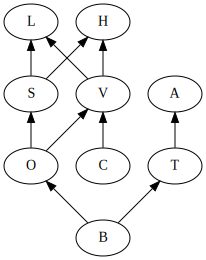

In [18]:
graphT = graph.transpose()
graphT.show(positions=pos)

### Exercise

Implement a method on the class BayesNet to learn each conditional factor. Since a Bayesian network contains factors over each variable, conditional on its parents, it's convienient to store each factor in a dictionary. The dictionary will associate each child variable name with a conditional factor: $\phi(child | parents)$.

Use the `estimateFactor(data, var_name, parent_names, outcomeSpace)` function to calculate probability tables for all 9 variables in our DAG (Bayesian network structure in the theory part of the tutorial).

In [19]:
class BayesNet(BayesNet):
    def learnParameters(self, data):
        '''
        Iterate over each node in the graph, and use the given data
        to estimate the factor P(node|parents), then add the new factor 
        to the `self.factors` dictionary.
        '''
        graphT = self.graph.transpose()
        for node, parents in graphT.adj_list.items():
            # TODO estimate each factor and add it to the `self.factors` dictionary
            ...
            
##############################
# Test code
##############################            
model = BayesNet(graph, outcomeSpace)
model.learnParameters(data)
print('estimated P(H)=')
print(model.factors['H'])
print('estimated P(V|H,L)=')
print(model.factors['V'])

estimated P(H)=


KeyError: 'H'

If you implemented this code correctly, you should see an output like this:
    
```
estimated P(H)=
╒═════╤═══════╕
│   H │    Pr │
╞═════╪═══════╡
│   0 │ 0.801 │
├─────┼───────┤
│   1 │ 0.199 │
╘═════╧═══════╛

estimated P(V|H,L)=
╒═════╤═════╤═════╤═══════════╕
│   L │   H │   V │        Pr │
╞═════╪═════╪═════╪═══════════╡
│   0 │   0 │   0 │ 0.0447958 │
├─────┼─────┼─────┼───────────┤
│   0 │   0 │   1 │ 0.955204  │
├─────┼─────┼─────┼───────────┤
│   0 │   1 │   0 │ 0.994764  │
├─────┼─────┼─────┼───────────┤
│   0 │   1 │   1 │ 0.0052356 │
├─────┼─────┼─────┼───────────┤
│   1 │   0 │   0 │ 0         │
├─────┼─────┼─────┼───────────┤
│   1 │   0 │   1 │ 1         │
├─────┼─────┼─────┼───────────┤
│   1 │   1 │   0 │ 1         │
├─────┼─────┼─────┼───────────┤
│   1 │   1 │   1 │ 0         │
╘═════╧═════╧═════╧═══════════╛
```

# Conditional probabilities by naïve summation

We are interested in calculating the conditional distributions.
For the moment we will attempt to find the conditional distribution
$p(L\mid C=\text{high})$.

We will compute $p(L\mid C=\text{high})$ by naïve summation.

To do this, we will need to reconstruct each of the joint probabilities from our graph.
Remember that we know that we know a factorization for the joint probabilities,
specifically,

$$p(B,T,O,C,V,S,H,L,A)=p(B\mid O,T)p(T\mid A)p(O\mid V,S)p(C\mid V)p(V\mid H,L)p(S\mid H,L)p(H)p(L)p(A)$$

To calculate this, we will need the factor multiplication operation we implemented in the previous tutorial (Week 2). We called this operation a `factor join`. Recall how we use this method.

In [21]:
factor1 = model.factors['H']
factor2 = model.factors['V']
print("join p(V|H,L) and p(H):")
print(factor1.join(factor2))

# Equivalently, we can do:
# print(factor1*factor2)

join p(V|H,L) and p(H):
╒═════╤═════╤═════╤════════════╕
│   H │   V │   L │         Pr │
╞═════╪═════╪═════╪════════════╡
│   0 │   0 │   0 │ 0.0358814  │
├─────┼─────┼─────┼────────────┤
│   0 │   0 │   1 │ 0          │
├─────┼─────┼─────┼────────────┤
│   0 │   1 │   0 │ 0.765119   │
├─────┼─────┼─────┼────────────┤
│   0 │   1 │   1 │ 0.801      │
├─────┼─────┼─────┼────────────┤
│   1 │   0 │   0 │ 0.197958   │
├─────┼─────┼─────┼────────────┤
│   1 │   0 │   1 │ 0.199      │
├─────┼─────┼─────┼────────────┤
│   1 │   1 │   0 │ 0.00104188 │
├─────┼─────┼─────┼────────────┤
│   1 │   1 │   1 │ 0          │
╘═════╧═════╧═════╧════════════╛



### Exercise

Now, implement a function that calculates the full joint probability of the Bayesian network model by multiplying all conditional distributions estimated from data. 

In [23]:
class BayesNet(BayesNet):
    def joint(self):
        '''
        Join every factor in the network, and return the resulting factor.
        '''
        factor_list = list(self.factors.values())
        
        accumulator = factor_list[0]
        ... # TODO join every factor in the list (requires loop)
        
        return accumulator
    
#########################
# Test code
#########################
model = BayesNet(graph, outcomeSpace)
model.learnParameters(data)
p = model.joint()
print(p)

╒═════╤══════╕
│   L │   Pr │
╞═════╪══════╡
│   0 │ 0.95 │
├─────┼──────┤
│   1 │ 0.05 │
╘═════╧══════╛



The correct implementation should provide the following output. The columns may be in a different order, depending on the order that the factors were joined. At least you can compare the first row.

Notice the size of this table as well as some very small probability values. We can realize how difficult it is to elicit such a probability table from a domain expert. It is much easier to work with smaller conditional tables.

```
╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════════════╕
│   L │   H │   S │   V │   O │   A │   T │   C │   B │          Pr │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════════════╡
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   0 │   0 │ 0.000363366 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   0 │   1 │ 0           │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   0 │   2 │ 0           │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   1 │   0 │ 1.66682e-05 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   1 │   1 │ 0           │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   1 │   2 │ 0           │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────────────┤
│   0 │   0 │   0 │   0 │   0 │   0 │   0 │   2 │   0 │ 6.66726e-06 │
...
```

# Answering Probabilistic Queries

Given the joint distribution, we can answer any probabilistic queries we like. For instance, the query we posed before, $p(L\mid C=\text{high})$.

We will need to eliminate variables through marginalization as well as observing evidence and renormalizing. We have implemented three functions to perform these tasks in Week 2 tutorial.

See [this](https://stackoverflow.com/a/36908) stackoverflow answer for the various uses of ** and * for packing and unpacking arguments, as used below.

In [23]:
# Reminder of how to use evidence, marginalize, normalize

# Create an empty factor ()
f = Factor(['A','B','C'], {'A':[0,1], 'B':[0,1,2], 'C':[0,1]})

# How to set evidence
evidence_dict = {'A':1, 'B':2}
f_with_evidence = f.evidence(**evidence_dict) 

# How to marginalize
f_without_c = f.marginalize('C')

# How to join 'f' and 'f_without_c'
f_joined = f.join(f_without_c)

### Exercise

Implement a method `query` that receives as arguments a list of variables and a list of evidence and returns $P(variables|evidence)$. 

In [25]:
class BayesNet(BayesNet):
    def query(self, q_vars, **q_evi):
        """
        arguments 
        `q_vars`, list of variables in query head
        `q_evi`, dictionary of evidence in the form of variables names and values

        Returns a new NORMALIZED factor will all hidden variables eliminated as evidence set as in q_evi
        """     

        # first we calculate the joint distribution
        f = self.joint()
        
        # Next, we set the evidence 
        f = ... # TODO

        # Second, we eliminate hidden variables NOT in the query
        ... # TODO
        
        # Finally, we normalize, then return the factor
        return ... # TODO

#########################
# Test code
#########################
model = BayesNet(graph, outcomeSpace)
model.learnParameters(data)
         
print(model.query('L', C=2))

Ellipsis


If your implementation is correct then you should see the following output:

```
╒═════╤═══════════╕
│   L │        Pr │
╞═════╪═══════════╡
│   0 │ 0.947912  │
├─────┼───────────┤
│   1 │ 0.0520882 │
╘═════╧═══════════╛
```

# Conditional independence

In this part, we will numerically estimate conditional independences.

## Exercise
Show or refute  the conditional independences in the theory tutorial numerically. i.e. 
determine whether

1. $H \indep L$
2. $H \indep A$
3. $C \indep L$

We can do this by examining the conditional versus marginal probabilities, e.g. 

$$H \indep L\Rightarrow p(H,L)=p(H)p(L)$$

Or,

$$H \indep L \Rightarrow p(H|L)=p(H).$$

It is your turn, we will leave three blank cells for you to develop your code. Use the functions we have implemented in the tutorials.

In [19]:
model = BayesNet(graph, outcomeSpace)
model.learnParameters(data)

... # TODO

Ellipsis

In [28]:
... # TODO

Ellipsis

In [30]:
... # TODO

Ellipsis

## Final Task
Create a python file called `BayesNet.py`, and copy the BayesNet class into this file (and the helper functions, and import statements). You will need this file for future tutorials.